# Simple Real Business Cycle Model

This notebook contains the example code from "State Space Estimation of Time Series Models in Python: Statsmodels" for the simple RBC model.

In [2]:
# These are the basic import statements to get the required Python functionality
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

## Data

For this example, we consider an RBC model in which output, labor, and consumption are the observable series.

In [3]:
# RBC model
from pandas_datareader.data import DataReader
start = '1984-01'
end = '2016-09'
labor = DataReader('HOANBS', 'fred',start=start, end=end).resample('QS').first()
cons = DataReader('PCECC96', 'fred', start=start, end=end).resample('QS').first()
inv = DataReader('GPDIC1', 'fred', start=start, end=end).resample('QS').first()
pop = DataReader('CNP16OV', 'fred', start=start, end=end)
pop = pop.resample('QS').mean()  # Convert pop from monthly to quarterly observations
recessions = DataReader('USRECQ', 'fred', start=start, end=end)
recessions = recessions.resample('QS').last()['USRECQ'].iloc[1:]

# Get in per-capita terms
N = labor['HOANBS'] * 6e4 / pop['CNP16OV']
C = (cons['PCECC96'] * 1e6 / pop['CNP16OV']) / 4
I = (inv['GPDIC1'] * 1e6 / pop['CNP16OV']) / 4
Y = C + I

# Log, detrend
y = np.log(Y).diff()[1:]
c = np.log(C).diff()[1:]
n = np.log(N).diff()[1:]
i = np.log(I).diff()[1:]
rbc_data = pd.concat((y, n, c), axis=1)
rbc_data.columns = ['output', 'labor', 'consumption']

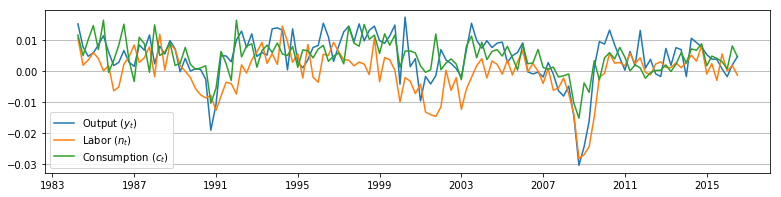

In [6]:
# Plot the series
fig, ax = plt.subplots(figsize=(13, 3), dpi=300)

ax.plot(y.index, y, label=r'Output $(y_t)$')
ax.plot(n.index, n, label=r'Labor $(n_t)$')
ax.plot(c.index, c, label=r'Consumption $(c_t)$')

ax.yaxis.grid()
ax.legend(loc='lower left', labelspacing=0.3);

## RBC Model

The simple RBC model considered here can be found in Ruge-Murcia (2007) or Dejong and Dave (2011). The non-linear system of equilibrium conditions is as follows:

$$
\begin{align}
\psi c_t & = (1 - \alpha) z_t \left ( \frac{k_t}{n_t} \right )^{\alpha} & \text{Static FOC} \\
\frac{1}{c_t} & = \beta E_t \left \{ \frac{1}{c_{t+1}} \left [ \alpha z_{t+1} \left ( \frac{k_{t+1}}{n_{t+1}} \right )^{\alpha - 1} + (1 - \delta) \right ] \right \} & \text{Euler equation} \\
y_t & = z_t k_t^\alpha n_t^{1 - \alpha} & \text{Production function} \\
y_t & = c_t + i_t & \text{Aggregate resource constraint} \\
k_{t+1} & = (1 - \delta) k_t + i_t & \text{Captial accumulation} \\
1 & = l_t + n_t & \text{Labor-leisure tradeoff} \\
\log z_t & = \rho \log z_{t-1} + \varepsilon_t & \text{Technology shock transition}
\end{align}
$$

by linearizing the model around the non-stochastic steady state, reducing the system to the three variables above, and solving with the method of Blanchard and Kahn (1980), we achieve a model in state space form.

The class ``SimpleRBC``, below, implements the log-linearization step in the ``log_linearize`` method and the Blanchard-Kahn solution in the ``solve`` method. The ``params`` vector for that class is the vector of *structural* parameters:

$$
\begin{align}
(& \beta, & \text{Discount rate}\\
& \psi, & \text{Marginal disutility of labor}\\
& \delta, & \text{Depreciation rate}\\
& \alpha, & \text{Capital-share of output}\\
& \rho, & \text{Technology shock persistence}\\
& \sigma^2 & \text{Technology shock variance} )
\end{align}$$

Also, the class below has a number of parameter transformations to ensure valid parameters. For example, ``transform_discount_rate`` takes as its argument a parameter that can vary over the entire real line and transformed it to lie in the set $(0, 1)$. This can be convenient when performing maximum likelihood estimation with some numerical optimization routines.

## State space form

After log-linearizing and solving the model, the resultant state space form is:

$$
\begin{align}
\begin{bmatrix} y_t \\ n_t \\ c_t \end{bmatrix} & = \underbrace{\begin{bmatrix}
        \phi_{yk} & \phi_{yz} \\
        \phi_{nk} & \phi_{nz} \\
        \phi_{ck} & \phi_{cz} \\
    \end{bmatrix}}_{Z} \underbrace{\begin{bmatrix} k_t \\ z_t \end{bmatrix}}_{\alpha_t} +
    \underbrace{\begin{bmatrix} \varepsilon_{y,t} \\ \varepsilon_{n,t} \\ \varepsilon_{c,t} \end{bmatrix}}_{\varepsilon_t}, \qquad \varepsilon_t \sim N \left ( \begin{bmatrix} 0 \\ 0 \\ 0\end{bmatrix}, \begin{bmatrix}
        \sigma_{y}^2 & 0 & 0 \\
        0 & \sigma_{n}^2 & 0 \\
        0 & 0 & \sigma_{c}^2 \\
    \end{bmatrix} \right ) \\
    \begin{bmatrix} k_{t+1} \\ z_{t+1} \end{bmatrix} & = \underbrace{\begin{bmatrix}
        T_{kk} & T_{kz} \\
        0      & \rho
    \end{bmatrix}}_{T} \begin{bmatrix} k_t \\ z_t \end{bmatrix} +
    \underbrace{\begin{bmatrix} 0 \\ 1 \end{bmatrix}}_{R}
    \eta_t, \qquad \eta_t \sim N(0, \sigma_z^2)
\end{align}
$$

where the reduced form parameters in the state space model are non-linear functions of the parameters in the RBC model, above.

The ``update`` method is called with a ``params`` vector holding the structural parameters. By log-linearizing and solving the model, those sturctural parameters are transformed into the reduced form parameters making up the state space form, and these are placed into the ``design``, ``obs_cov``, ``transition``, and ``state_cov`` matrices. Then the Kalman filter and smoother can be applied to retrieve smoothed estimates of the unobserved states, compute the log-likelihood for maximum likelihood estimation, or as part of the simulation smoother for Bayesian estimation.

In [7]:
from collections import OrderedDict
class SimpleRBC(sm.tsa.statespace.MLEModel):

    parameters = OrderedDict([
        ('discount_rate', 0.95),
        ('disutility_labor', 3.),
        ('depreciation_rate', 0.025),
        ('capital_share', 0.36),
        ('technology_shock_persistence', 0.85),
        ('technology_shock_var', 0.04**2)
    ])

    def __init__(self, endog, calibrated=None):
        super(SimpleRBC, self).__init__(
            endog, k_states=2, k_posdef=1, initialization='stationary')
        self.k_predetermined = 1

        # Save the calibrated vs. estimated parameters
        parameters = self.parameters.keys()
        calibrated = calibrated or {}
        self.calibrated = OrderedDict([
            (param, calibrated[param]) for param in parameters
            if param in calibrated
        ])
        self.idx_calibrated = np.array([
            param in self.calibrated for param in parameters])
        self.idx_estimated = ~self.idx_calibrated

        self.k_params = len(self.parameters)
        self.k_calibrated = len(self.calibrated)
        self.k_estimated = self.k_params - self.k_calibrated

        self.idx_cap_share = parameters.index('capital_share')
        self.idx_tech_pers = parameters.index('technology_shock_persistence')
        self.idx_tech_var = parameters.index('technology_shock_var')

        # Setup fixed elements of system matrices
        self['selection', 1, 0] = 1

    @property
    def start_params(self):
        structural_params = np.array(self.parameters.values())[self.idx_estimated]
        measurement_variances = [0.1] * 3
        return np.r_[structural_params, measurement_variances]

    @property
    def param_names(self):
        structural_params = np.array(self.parameters.keys())[self.idx_estimated]
        measurement_variances = ['%s.var' % name for name in self.endog_names]
        return structural_params.tolist() + measurement_variances

    def log_linearize(self, params):
        # Extract the parameters
        (discount_rate, disutility_labor, depreciation_rate, capital_share,
         technology_shock_persistence, technology_shock_var) = params

        # Temporary values
        tmp = (1. / discount_rate - (1. - depreciation_rate))
        theta = (capital_share / tmp)**(1. / (1. - capital_share))
        gamma = 1. - depreciation_rate * theta**(1. - capital_share)
        zeta = capital_share * discount_rate * theta**(capital_share - 1)

        # Coefficient matrices from linearization
        A = np.eye(2)

        B11 = 1 + depreciation_rate * (gamma / (1 - gamma))
        B12 = (-depreciation_rate *
               (1 - capital_share + gamma * capital_share) /
               (capital_share * (1 - gamma)))
        B21 = 0
        B22 = capital_share / (zeta + capital_share*(1 - zeta))
        B = np.array([[B11, B12], [B21, B22]])

        C1 = depreciation_rate / (capital_share * (1 - gamma))
        C2 = (zeta * technology_shock_persistence /
              (zeta + capital_share*(1 - zeta)))
        C = np.array([[C1], [C2]])

        return A, B, C

    def solve(self, params):
        capital_share = params[self.idx_cap_share]
        technology_shock_persistence = params[self.idx_tech_pers]

        # Get the coefficient matrices from linearization
        A, B, C = self.log_linearize(params)

        # Jordan decomposition of B
        eigvals, right_eigvecs = np.linalg.eig(np.transpose(B))
        left_eigvecs = np.transpose(right_eigvecs)

        # Re-order, ascending
        idx = np.argsort(eigvals)
        eigvals = np.diag(eigvals[idx])
        left_eigvecs = left_eigvecs[idx, :]

        # Blanchard-Kahn conditions
        k_nonpredetermined = self.k_states - self.k_predetermined
        k_stable = len(np.where(eigvals.diagonal() < 1)[0])
        k_unstable = self.k_states - k_stable
        if not k_stable == self.k_predetermined:
            raise RuntimeError('Blanchard-Kahn condition not met.'
                               ' Unique solution does not exist.')

        # Create partition indices
        k = self.k_predetermined
        p1 = np.s_[:k]
        p2 = np.s_[k:]

        p11 = np.s_[:k, :k]
        p12 = np.s_[:k, k:]
        p21 = np.s_[k:, :k]
        p22 = np.s_[k:, k:]

        # Decouple the system
        decoupled_C = np.dot(left_eigvecs, C)

        # Solve the explosive component (controls) in terms of the
        # non-explosive component (states) and shocks
        tmp = np.linalg.inv(left_eigvecs[p22])

        # This is \phi_{ck}, above
        policy_state = - np.dot(tmp, left_eigvecs[p21]).squeeze()
        # This is \phi_{cz}, above
        policy_shock = -(
            np.dot(tmp, 1. / eigvals[p22]).dot(
                np.linalg.inv(
                    np.eye(k_nonpredetermined) -
                    technology_shock_persistence / eigvals[p22]
                )
            ).dot(decoupled_C[p2])
        ).squeeze()

        # Solve for the non-explosive transition
        # This is T_{kk}, above
        transition_state = np.squeeze(B[p11] + np.dot(B[p12], policy_state))
        # This is T_{kz}, above
        transition_shock = np.squeeze(np.dot(B[p12], policy_shock) + C[p1])

        # Create the full design matrix
        tmp = (1 - capital_share) / capital_share
        tmp1 = 1. / capital_share
        design = np.array([[1 - tmp * policy_state, tmp1 - tmp * policy_shock],
                           [1 - tmp1 * policy_state, tmp1 * (1-policy_shock)],
                           [policy_state,            policy_shock]])

        # Create the transition matrix
        transition = (
            np.array([[transition_state, transition_shock],
                      [0,                technology_shock_persistence]]))

        return design, transition

    def transform_discount_rate(self, param, untransform=False):
        # Discount rate must be between 0 and 1
        epsilon = 1e-4  # bound it slightly away from exactly 0 or 1
        if not untransform:
            return np.abs(1 / (1 + np.exp(param)) - epsilon)
        else:
            return np.log((1 - param + epsilon) / (param + epsilon))

    def transform_disutility_labor(self, param, untransform=False):
        # Disutility of labor must be positive
        return param**2 if not untransform else param**0.5

    def transform_depreciation_rate(self, param, untransform=False):
        # Depreciation rate must be positive
        return param**2 if not untransform else param**0.5

    def transform_capital_share(self, param, untransform=False):
        # Capital share must be between 0 and 1
        epsilon = 1e-4  # bound it slightly away from exactly 0 or 1
        if not untransform:
            return np.abs(1 / (1 + np.exp(param)) - epsilon)
        else:
            return np.log((1 - param + epsilon) / (param + epsilon))

    def transform_technology_shock_persistence(self, param, untransform=False):
        # Persistence parameter must be between -1 and 1
        if not untransform:
            return param / (1 + np.abs(param))
        else:
            return param / (1 - param)

    def transform_technology_shock_var(self, unconstrained, untransform=False):
        # Variances must be positive
        return unconstrained**2 if not untransform else unconstrained**0.5

    def transform_params(self, unconstrained):
        constrained = np.zeros(unconstrained.shape, unconstrained.dtype)

        i = 0
        for param in self.parameters.keys():
            if param not in self.calibrated:
                method = getattr(self, 'transform_%s' % param)
                constrained[i] = method(unconstrained[i])
                i += 1

        # Measurement error variances must be positive
        constrained[self.k_estimated:] = unconstrained[self.k_estimated:]**2

        return constrained

    def untransform_params(self, constrained):
        unconstrained = np.zeros(constrained.shape, constrained.dtype)

        i = 0
        for param in self.parameters.keys():
            if param not in self.calibrated:
                method = getattr(self, 'transform_%s' % param)
                unconstrained[i] = method(constrained[i], untransform=True)
                i += 1

        # Measurement error variances must be positive
        unconstrained[self.k_estimated:] = constrained[self.k_estimated:]**0.5

        return unconstrained

    def update(self, params, **kwargs):
        params = super(SimpleRBC, self).update(params, **kwargs)

        # Reconstruct the full parameter vector from the
        # estimated and calibrated parameters
        structural_params = np.zeros(self.k_params, dtype=params.dtype)
        structural_params[self.idx_calibrated] = self.calibrated.values()
        structural_params[self.idx_estimated] = params[:self.k_estimated]
        measurement_variances = params[self.k_estimated:]

        # Solve the model
        design, transition = self.solve(structural_params)

        # Update the statespace representation
        self['design'] = design
        self['obs_cov', 0, 0] = measurement_variances[0]
        self['obs_cov', 1, 1] = measurement_variances[1]
        self['obs_cov', 2, 2] = measurement_variances[2]
        self['transition'] = transition
        self['state_cov', 0, 0] = structural_params[self.idx_tech_var]


## Calibration / Maximum likelihood estimation

It is sometimes interesting to calibrate the structural parameters of the model, and estimate only the measurement error variables.

In [33]:
# Calibrate everything except measurement variances
calibrated = {
    'discount_rate': 0.95,
    'disutility_labor': 3.0,
    'capital_share': 0.36,
    'depreciation_rate': 0.025,
    'technology_shock_persistence': 0.85,
    'technology_shock_var': 0.04**2
}
calibrated_mod = SimpleRBC(rbc_data, calibrated=calibrated)
calibrated_res = calibrated_mod.fit(method='nm', maxiter=1000, disp=0)

calibrated_irfs = calibrated_res.impulse_responses(40, orthogonalized=True) * 100
print(calibrated_res.summary())

                                   Statespace Model Results                                   
Dep. Variable:     ['output', 'labor', 'consumption']   No. Observations:                  130
Model:                                      SimpleRBC   Log Likelihood                1221.724
Date:                                Sat, 28 Jan 2017   AIC                          -2437.447
Time:                                        14:20:15   BIC                          -2428.845
Sample:                                    04-01-1984   HQIC                         -2433.952
                                         - 07-01-2016                                         
Covariance Type:                                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
output.var       1.902e-11   6.65e-06   2.86e-06      1.000    -1.3e-05 

## Output plots

Because we're going to be making the same plots for a couple of examples, we define a function here to do that for us.

In [62]:
from scipy.stats import norm

def plot_irfs(irfs):
    fig, ax = plt.subplots(figsize=(13, 2), dpi=300)

    lines, = ax.plot(irfs['output'], label='')
    ax.plot(irfs['output'], 'o', label='Output', color=lines.get_color(),
            markersize=4, alpha=0.8)
    lines, = ax.plot(irfs['labor'], label='')
    ax.plot(irfs['labor'], '^', label='Labor', color=lines.get_color(),
            markersize=4, alpha=0.8)
    lines, = ax.plot(irfs['consumption'], label='')
    ax.plot(irfs['consumption'], 's', label='Consumption',
            color=lines.get_color(), markersize=4, alpha=0.8)

    ax.hlines(0, 0, irfs.shape[0], alpha=0.9, linestyle=':', linewidth=1)
    ylim = ax.get_ylim()
    ax.vlines(0, ylim[0]+1e-6, ylim[1]-1e-6, alpha=0.9, linestyle=':',
              linewidth=1)
    [ax.spines[spine].set(linewidth=0) for spine in ['top', 'right']]
    ax.set(xlabel='Quarters after impulse', ylabel='Impulse response (\%)',
           xlim=(-1, len(irfs)))

    ax.legend(labelspacing=0.3)
    
    return fig

def plot_states(res):
    fig, ax = plt.subplots(figsize=(13, 3), dpi=300)

    alpha = 0.1
    q = norm.ppf(1 - alpha / 2)

    capital = res.smoothed_state[0, :]
    capital_se = res.smoothed_state_cov[0, 0, :]**0.5
    capital_lower = capital - capital_se * q
    capital_upper = capital + capital_se * q

    shock = res.smoothed_state[1, :]
    shock_se = res.smoothed_state_cov[1, 1, :]**0.5
    shock_lower = shock - shock_se * q
    shock_upper = shock + shock_se * q

    line_capital, = ax.plot(rbc_data.index, capital, label='Capital')
    ax.fill_between(rbc_data.index, capital_lower, capital_upper, alpha=0.25,
                    color=line_capital.get_color())

    line_shock, = ax.plot(rbc_data.index, shock, label='Technology process')
    ax.fill_between(rbc_data.index, shock_lower, shock_upper, alpha=0.25,
                    color=line_shock.get_color())

    ax.hlines(0, rbc_data.index[0], rbc_data.index[-1], 'k')
    ax.yaxis.grid()

    ylim = ax.get_ylim()
    ax.fill_between(recessions.index, ylim[0]+1e-5, ylim[1]-1e-5, recessions,
                    facecolor='k', alpha=0.1)

    p1 = plt.Rectangle((0, 0), 1, 1, fc="grey", alpha=0.3)
    ax.legend([line_capital, line_shock, p1],
              ["Capital", "Technology process", "NBER recession indicator"],
              loc='lower left');
    
    return fig

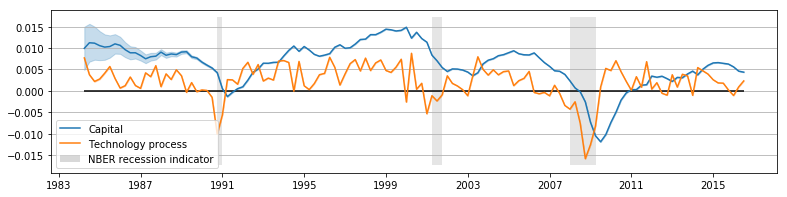

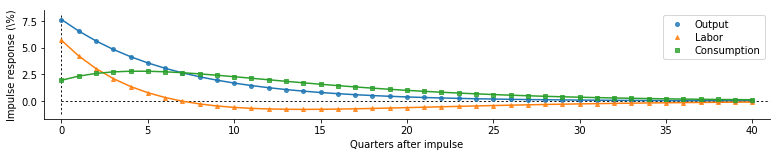

In [63]:
plot_states(calibrated_res);
plot_irfs(calibrated_irfs);

## Maximum likelihood estimation

We can try to estimate more parameters.

In [64]:
# Now, don't calibrate the technology parameters
partially_calibrated = {
    'discount_rate': 0.95,
    'disutility_labor': 3.0,
    'capital_share': 0.33,
    'depreciation_rate': 0.025,
}
partial_mod = SimpleRBC(rbc_data, calibrated=partially_calibrated)
partial_res = partial_mod.fit(method='nm', maxiter=1000, disp=0)

partial_irfs = partial_res.impulse_responses(40, orthogonalized=True) * 100
print(partial_res.summary())

                                   Statespace Model Results                                   
Dep. Variable:     ['output', 'labor', 'consumption']   No. Observations:                  130
Model:                                      SimpleRBC   Log Likelihood                1494.643
Date:                                Sat, 28 Jan 2017   AIC                          -2979.285
Time:                                        14:27:04   BIC                          -2964.948
Sample:                                    04-01-1984   HQIC                         -2973.459
                                         - 07-01-2016                                         
Covariance Type:                                  opg                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
technology_shock_persistence     0.9372      0

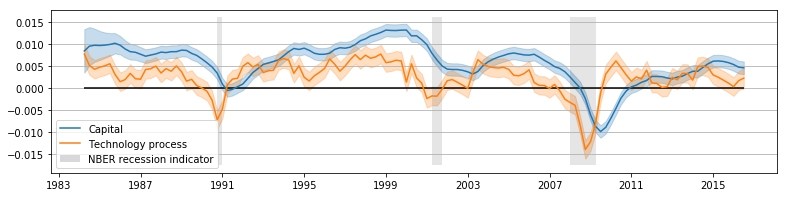

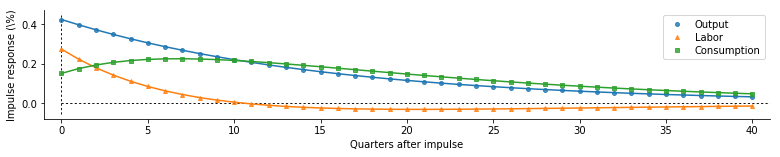

In [65]:
plot_states(partial_res);
plot_irfs(partial_irfs);

## Metropolis-within-Gibbs Sampling

In [74]:
def draw_posterior_rho(model, states, sigma2, truncate=False):
    Z = states[1:2, 1:]
    X = states[1:2, :-1]

    tmp = 1 / (sigma2 + np.sum(X**2))
    post_mean = tmp * np.squeeze(np.dot(X, Z.T))
    post_var = tmp * sigma2

    if truncate:
        lower = (-1 - post_mean) / post_var**0.5
        upper = (1 - post_mean) / post_var**0.5
        rvs = truncnorm.rvs(lower, upper, loc=post_mean, scale=post_var**0.5)
    else:
        rvs = norm.rvs(post_mean, post_var**0.5)
    return rvs

def draw_posterior_sigma2(model, states, rho):
    resid = states[1, 1:] - rho * states[1, :-1]
    post_shape = 2.00005 + model.nobs
    post_scale = 0.0100005 + np.sum(resid**2)

    return invgamma.rvs(post_shape, scale=post_scale)

np.set_printoptions(suppress=True)
np.random.seed(17429)

from statsmodels.tsa.statespace.tools import is_invertible
from scipy.stats import multivariate_normal, gamma, invgamma, beta, uniform

# Create the model for likelihood evaluation
calibrated = {
    'disutility_labor': 3.0,
    'depreciation_rate': 0.025,
}
model = SimpleRBC(rbc_data, calibrated=calibrated)
sim_smoother = model.simulation_smoother()

# Specify priors
prior_discount = gamma(6.25, scale=0.04)
prior_cap_share = norm(0.3, scale=0.01)
prior_meas_err = invgamma(2.0025, scale=0.10025)

# Proposals
rw_discount = norm(scale=0.3)
rw_cap_share = norm(scale=0.01)
rw_meas_err = norm(scale=0.003)

# Create storage arrays for the traces
n_iterations = 10000
trace = np.zeros((n_iterations + 1, 7))
trace_accepts = np.zeros((n_iterations, 5))
trace[0] = model.start_params
trace[0, 0] = 100 * ((1 / trace[0, 0]) - 1)

loglike = None

# Iterations
for s in range(1, n_iterations + 1):
    if s % 1000 == 0:
        print s
    # Get the parameters from the trace
    discount_rate = 1 / (1 + (trace[s-1, 0] / 100))
    capital_share = trace[s-1, 1]
    rho = trace[s-1, 2]
    sigma2 = trace[s-1, 3]
    meas_vars = trace[s-1, 4:]**2

    # 1. Gibbs step: draw the states using the simulation smoother
    model.update(np.r_[discount_rate, capital_share, rho, sigma2, meas_vars])
    sim_smoother.simulate()
    states = sim_smoother.simulated_state[:, :-1]

    # 2. Gibbs step: draw the autoregressive parameter, and apply
    # rejection sampling to ensure an invertible lag polynomial
    # In rare cases due to the combinations of other parameters,
    # the mean of the normal posterior will be greater than one
    # and it becomes difficult to draw from a normal distribution
    # even with rejection sampling. In those cases we draw from a
    # truncated normal.
    rho = draw_posterior_rho(model, states, sigma2)
    i = 0
    while rho < -1 or rho > 1:
        if i < 1e2:
            rho = draw_posterior_rho(model, states, sigma2)
        else:
            rho = draw_posterior_rho(model, states, sigma2, truncate=True)
        i += 1
    trace[s, 2] = rho

    # 3. Gibbs step: draw the variance parameter
    sigma2 = draw_posterior_sigma2(model, states, rho)
    trace[s, 3] = sigma2

    # Calculate the loglikelihood
    loglike = model.loglike(np.r_[discount_rate, capital_share, rho, sigma2, meas_vars])

    # 4. Metropolis-step for the discount rate
    discount_param = trace[s-1, 0]
    proposal_param = discount_param + rw_discount.rvs()
    proposal_rate = 1 / (1 + (proposal_param / 100))
    if proposal_rate < 1:
        proposal_loglike = model.loglike(np.r_[proposal_rate, capital_share, rho, sigma2, meas_vars])
        acceptance_probability = np.exp(
            proposal_loglike - loglike +
            prior_discount.logpdf(proposal_param) -
            prior_discount.logpdf(discount_param))

        if acceptance_probability > uniform.rvs():
            discount_param = proposal_param
            discount_rate = proposal_rate
            loglike = proposal_loglike
            trace_accepts[s-1, 0] = 1

    trace[s, 0] = discount_param

    # 5. Metropolis-step for the capital-share
    proposal = capital_share + rw_cap_share.rvs()
    if proposal > 0 and proposal < 1:
        proposal_loglike = model.loglike(np.r_[discount_rate, proposal, rho, sigma2, meas_vars])
        acceptance_probability = np.exp(
            proposal_loglike - loglike +
            prior_cap_share.logpdf(proposal) -
            prior_cap_share.logpdf(capital_share))

        if acceptance_probability > uniform.rvs():
            capital_share = proposal
            trace_accepts[s-1, 1] = 1
            loglike = proposal_loglike
    trace[s, 1] = capital_share

    # 6. Metropolis-step for the measurement errors
    for i in range(3):
        meas_std = meas_vars[i]**0.5
        proposal = meas_std + rw_meas_err.rvs()
        proposal_vars = meas_vars.copy()
        proposal_vars[i] = proposal**2
        if proposal > 0:
            proposal_loglike = model.loglike(np.r_[discount_rate, capital_share, rho, sigma2, proposal_vars])
            acceptance_probability = np.exp(
                proposal_loglike - loglike +
                prior_meas_err.logpdf(proposal) -
                prior_meas_err.logpdf(meas_std))

            if acceptance_probability > uniform.rvs():
                meas_std = proposal
                trace_accepts[s-1, 2+i] = 1
                loglike = proposal_loglike
                meas_vars[i] = proposal_vars[i]
        trace[s, 4+i] = meas_std


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [118]:
from scipy.stats import gaussian_kde

burn = 1000
thin = 10

final_trace = trace.copy()
final_trace = final_trace[burn:][::thin]
final_trace[:, 0] = 1 / (1 + (final_trace[:, 0] / 100))
final_trace[:, 4:] = final_trace[:, 4:]**2

modes = np.zeros(7)
means = np.mean(final_trace, axis=0)
discount_kde = gaussian_kde(final_trace[:, 0])
cap_share_kde = gaussian_kde(final_trace[:, 1])
rho_kde = gaussian_kde(final_trace[:, 2])
sigma2_kde = gaussian_kde(final_trace[:, 3])

# Finish calculating modes
for i in range(7):
    kde = gaussian_kde(final_trace[:, i])
    X = np.linspace(np.min(final_trace[:, i]),
                    np.max(final_trace[:, i]), 1000)
    Y = kde(X)
    modes[i] = X[np.argmax(Y)]

test = pd.DataFrame(final_trace)

print(pd.DataFrame(
    np.c_[modes, means, test.quantile(q=0.05), test.quantile(q=0.95)],
    columns=['Mode', 'Mean', '5 percent', '95 percent']
).to_string(float_format=lambda x: '%.3g' % x))

      Mode     Mean  5 percent  95 percent
0    0.997    0.996      0.994       0.998
1    0.329    0.326      0.309       0.344
2    0.647    0.624      0.269       0.946
3 8.21e-05  8.3e-05   7.07e-05    9.52e-05
4 2.01e-05 2.11e-05   1.35e-05    2.97e-05
5 2.93e-05 3.02e-05   2.18e-05    4.09e-05
6 2.44e-05 2.45e-05   1.86e-05    3.15e-05


### Sampler output

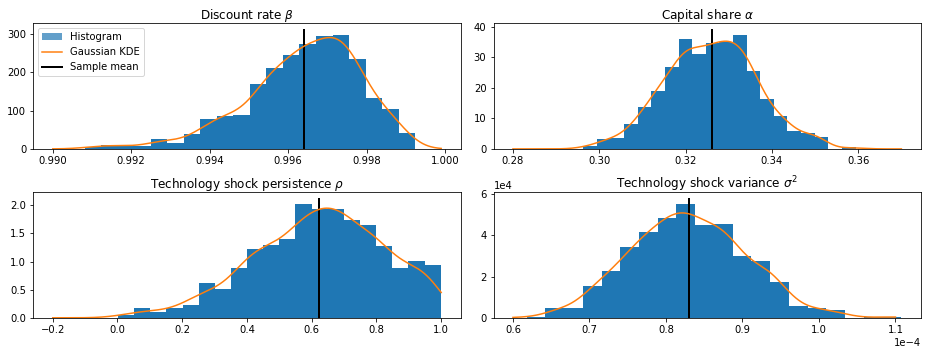

In [115]:
# Trace plots
fig, axes = plt.subplots(2, 2, figsize=(13, 5), dpi=300)

axes[0, 0].hist(final_trace[:, 0], bins=20, normed=True, alpha=1)
X = np.linspace(0.990, 1.0-1e-4, 1000)
Y = discount_kde(X)
modes[0] = X[np.argmax(Y)]
line, = axes[0, 0].plot(X, Y)
ylim = axes[0, 0].get_ylim()
vline = axes[0, 0].vlines(means[0], ylim[0], ylim[1], linewidth=2)
axes[0, 0].set(title=r'Discount rate $\beta$')

axes[0, 1].hist(final_trace[:, 1], bins=20, normed=True, alpha=1)
X = np.linspace(0.280, 0.370, 1000)
Y = cap_share_kde(X)
modes[1] = X[np.argmax(Y)]
axes[0, 1].plot(X, Y)
ylim = axes[0, 1].get_ylim()
vline = axes[0, 1].vlines(means[1], ylim[0], ylim[1], linewidth=2)
axes[0, 1].set(title=r'Capital share $\alpha$')

axes[1, 0].hist(final_trace[:, 2], bins=20, normed=True, alpha=1)
X = np.linspace(-0.2, 1-1e-4, 1000)
Y = rho_kde(X)
modes[2] = X[np.argmax(Y)]
axes[1, 0].plot(X, Y)
ylim = axes[1, 0].get_ylim()
vline = axes[1, 0].vlines(means[2], ylim[0], ylim[1], linewidth=2)
axes[1, 0].set(title=r'Technology shock persistence $\rho$')

axes[1, 1].hist(final_trace[:, 3], bins=20, normed=True, alpha=1)
X = np.linspace(0.6e-4, 1.1e-4, 1000)
Y = sigma2_kde(X)
modes[3] = X[np.argmax(Y)]
axes[1, 1].plot(X, Y)
ylim = axes[1, 1].get_ylim()
vline = axes[1, 1].vlines(means[3], ylim[0], ylim[1], linewidth=2)
axes[1, 1].ticklabel_format(style='sci', scilimits=(-2, 2))
axes[1, 1].set(title=r'Technology shock variance $\sigma^2$')

p1 = plt.Rectangle((0, 0), 1, 1, alpha=0.7)
axes[0, 0].legend([p1, line, vline],
                  ["Histogram", "Gaussian KDE", "Sample mean"],
                  loc='upper left')
fig.tight_layout()

### Model of the posterior median

One way to explore the implications of the posterior is to example the model at the posterior mean or median.

In [107]:
gibbs_res = model.smooth(np.median(final_trace, axis=0))
print(gibbs_res.summary())

gibbs_irfs = gibbs_res.impulse_responses(40, orthogonalized=True)*100

                                   Statespace Model Results                                   
Dep. Variable:     ['output', 'labor', 'consumption']   No. Observations:                  130
Model:                                      SimpleRBC   Log Likelihood                1347.991
Date:                                Sat, 28 Jan 2017   AIC                          -2681.982
Time:                                        14:43:18   BIC                          -2661.910
Sample:                                    04-01-1984   HQIC                         -2673.826
                                         - 07-01-2016                                         
Covariance Type:                                  opg                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
discount_rate                    0.9966      0

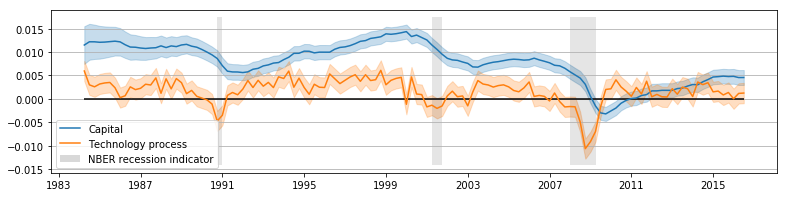

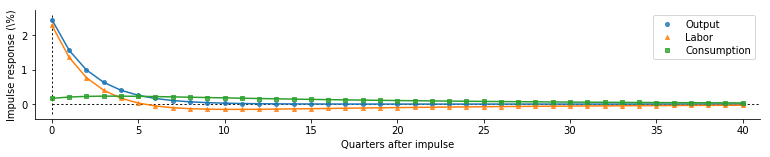

In [108]:
plot_states(gibbs_res);
plot_irfs(gibbs_irfs);